In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
data_org = pd.read_excel("/gdrive/My Drive/Colab Notebooks/한국어_단발성_대화_데이터셋.xlsx")[['Sentence', 'Emotion']]

In [4]:
data_org

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
38589,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,혐오
38590,재미가 없으니 망하지,혐오
38591,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,혐오
38592,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,혐오


# 데이터 중복 제거

In [5]:
data_org.nunique()

Sentence    38509
Emotion         7
dtype: int64

* sentence중에 중복 존재. emotion 7개. 

In [6]:
data = data_org.drop_duplicates(subset=['Sentence'])

In [7]:
data['Emotion'].unique()

array(['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'], dtype=object)

In [8]:
data.count()

Sentence    38509
Emotion     38509
dtype: int64

In [9]:
data['Emotion'].value_counts()

행복    6003
놀람    5886
분노    5662
공포    5461
혐오    5426
슬픔    5244
중립    4827
Name: Emotion, dtype: int64

In [10]:
# np.save('/gdrive/My Drive/Colab Notebooks/y_org', np.array(data['Emotion']))

# 텍스트 토큰화 (konlpy의 okt 사용), 불용어 제거, 이모티콘 축약(정규화)

In [11]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 448 kB 59.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [12]:
!pip install soynlp

     |████████████████████████████████| 416 kB 7.1 MB/s 


In [13]:
from konlpy.tag import Okt
from soynlp.normalizer import *

In [14]:
okt = Okt()

In [15]:
X_morph = []
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '다', '이다', '로', '요', '고', '을', '.', ',']
norm = ['!', '?', 'ㅠ', 'ㅋ', 'ㅎ', '.', '~', ',', ';', '^', 'ㄷ', 'ㅡ']
for sent in data['Sentence']:
  e_nor = emoticon_normalize(sent, num_repeats=2)
  tokenized = okt.morphs(e_nor, stem=True)
  sw_removed = [word for word in tokenized if not word in stopwords]
  normalized = []
  for word in sw_removed:
    changed = False
    for n in norm: ## 두번 이상 나온 이모티콘 정규화
      if n in word:
        normalized.append(n)
        changed = True
    if 'ㅜ' in word: ## ㅜ를 ㅠ로 변환
      normalized.append('ㅠ')
      changed = True
    
    if not changed:
      normalized.append(word)
  X_morph.append(normalized)

In [16]:
len(X_morph)

38509

In [17]:
X_morph[:3]

[['언니', '동생', '부르다', '맞다', '일', '인가요', '?', '.'],
 ['그냥', '내', '느낌', '일', '뿐', '겠다', '?'],
 ['아직', '너무', '초기', '라서', '그런', '거', '죠', '?']]

In [18]:
# np.save('/gdrive/My Drive/Colab Notebooks/X_morph', X_morph)

# 라벨 인코딩: 공포-0, 놀람-1, 분노-2, 슬픔-3, 중립-4, 행복-5, 혐오-6

In [19]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(data['Emotion'])

In [20]:
enc.classes_

array(['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'], dtype=object)

# train-test split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_morph, y, test_size=0.3, random_state=777, stratify=y)

In [22]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([1638, 1766, 1699, 1573, 1448, 1801, 1628]))

# tokenizer 이용하여 단어 종류, 개수 파악

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
threshold = 4
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합 크기 :',total_cnt)
print('출현빈도가 %s번 미만 단어 수: %s'%(threshold, rare_cnt))
print("희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합 크기 : 20017
출현빈도가 4번 미만 단어 수: 14229
희귀 단어의 비율: 71.08457810860769
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.662433299293799


In [26]:
voca_threshold = total_cnt - rare_cnt + 1
voca_threshold # 등장 빈도가 4번 이상인 단어 순위

5789

In [27]:
tokenizer.index_word

# Bag of Word 생성. 

In [28]:
# BoW
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer=lambda x: x, max_features=voca_threshold) # 최대 feature 수 = 출현빈도 4개 이상인 단어 순위
X_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test).toarray()

In [29]:
X_train_bow = X_bow.toarray()

In [30]:
X_train_bow.shape

(26956, 5789)

In [31]:
y_train.shape

(26956,)

# multinomial naive bayes 기본 적용. acc = 0.4838

In [32]:
from sklearn.naive_bayes import MultinomialNB
nbc = MultinomialNB()

In [33]:
nbc.fit(X_train_bow, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [34]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train, nbc.predict(X_train_bow)))
print(accuracy_score(y_test, nbc.predict(X_test_bow)))

0.6331428995399911
0.4838570068380507


In [35]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, nbc.predict(X_train_bow)))
print(confusion_matrix(y_test, nbc.predict(X_test_bow)))

[[2516  373  116  443  142   86  147]
 [ 459 2510  242  227  213  260  209]
 [ 143  280 2550  160  212  116  502]
 [ 439  143   97 2636  100  140  116]
 [ 277  454  325  193 1533  282  315]
 [  93  204   89  173  154 3394   95]
 [ 179  344  748  206  269  124 1928]]
[[ 874  228   51  278   97   48   62]
 [ 267  830  128  117  173  130  121]
 [  81  140  789   94  124   57  414]
 [ 275   76   54  955   61   88   64]
 [ 178  265  165  127  354  155  204]
 [  55  129   43   95   93 1331   55]
 [  98  194  493  110  198   78  457]]


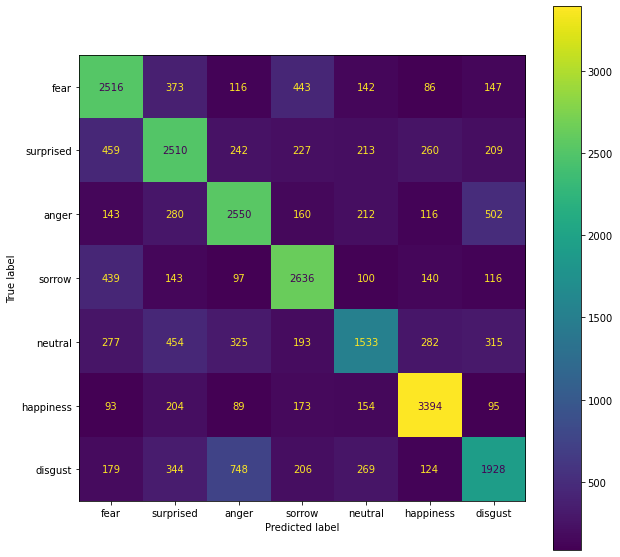

In [36]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
labels = ['fear', 'surprised', 'anger', 'sorrow', 'neutral', 'happiness', 'disgust']
plot_confusion_matrix(nbc, X_train_bow, y_train, display_labels=labels, values_format = '0.0f', ax=ax)

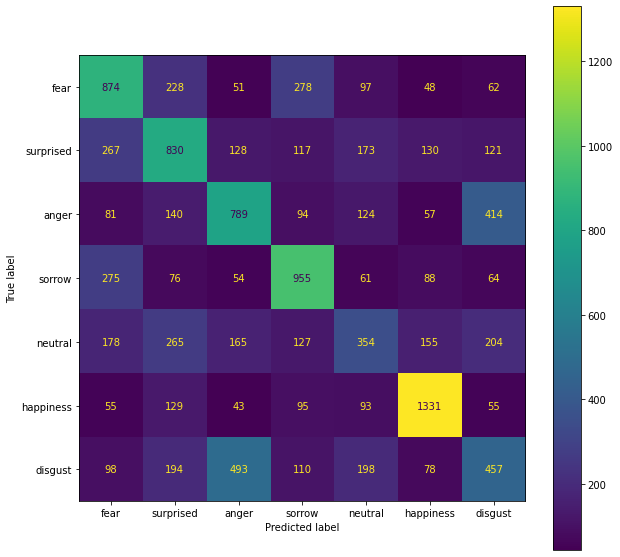

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(nbc, X_test_bow, y_test, display_labels=labels, values_format = '.0f', ax=ax)

# BoW에 Tf-idf 적용. NB accuracy 유의미한 변화 없음. 그러나 속도 빠름. 
* 자주 등장하는 단어의 가중치 낮춤. 

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

In [39]:
np.set_printoptions(precision=2)
X_train_tf = tfidf.fit_transform(X_train_bow)
X_test_tf = tfidf.transform(X_test_bow)

In [40]:
nbc2 = MultinomialNB()
nbc2.fit(X_train_tf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [41]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train, nbc2.predict(X_train_tf)))
print(accuracy_score(y_test, nbc2.predict(X_test_tf)))

0.6333283870010388
0.4800484722582879


# NB Grid Search 1. alpha: [0.1, 1, 10, 50, 100, 500, 1000] best: alpha=1 (default값과 같음)

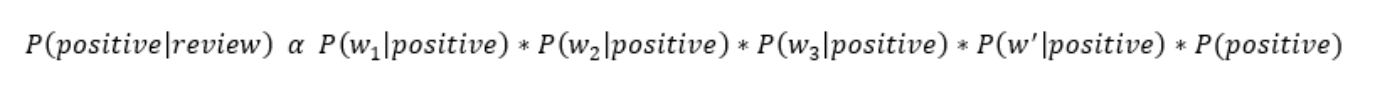

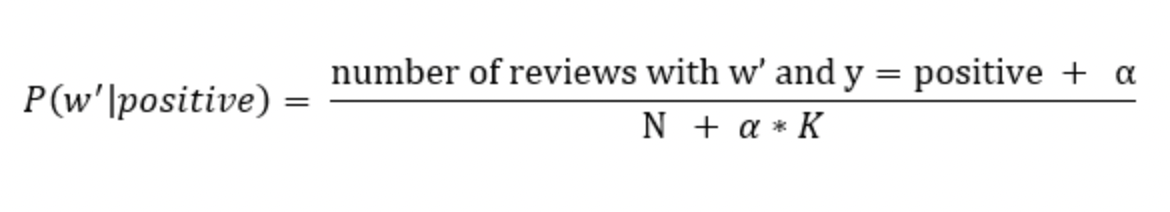

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 1, 10, 50, 100, 500, 1000]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)

In [43]:
grid.fit(X_train_bow, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 1, 10, 50, 100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [44]:
grid.cv_results_

{'mean_fit_time': array([6.13, 6.16, 6.11, 6.12, 6.08, 6.12, 6.11]),
 'mean_score_time': array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14]),
 'mean_test_score': array([0.45, 0.48, 0.47, 0.44, 0.42, 0.38, 0.35]),
 'param_alpha': masked_array(data=[0.1, 1, 10, 50, 100, 500, 1000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 50},
  {'alpha': 100},
  {'alpha': 500},
  {'alpha': 1000}],
 'rank_test_score': array([3, 1, 2, 4, 5, 6, 7], dtype=int32),
 'split0_test_score': array([0.45, 0.48, 0.46, 0.44, 0.42, 0.37, 0.35]),
 'split1_test_score': array([0.45, 0.47, 0.46, 0.43, 0.42, 0.38, 0.35]),
 'split2_test_score': array([0.46, 0.48, 0.48, 0.45, 0.43, 0.38, 0.35]),
 'split3_test_score': array([0.46, 0.48, 0.47, 0.44, 0.42, 0.37, 0.35]),
 'split4_test_score': array([0.45, 0.47, 0.46, 0.44, 0.42, 0.37, 0.35]),
 'std_fit_time': array([0.07, 0.02, 0

In [45]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train, grid.best_estimator_.predict(X_train_bow)))
print(accuracy_score(y_test, grid.best_estimator_.predict(X_test_bow)))

0.6331428995399911
0.4838570068380507


# NB Grid Search 2. alpha: [0.5, 1, 4, 6] best: alpha=4. acc=0.4862

In [46]:
param_grid2 = {'alpha': [0.5, 1, 4, 6]}
grid2 = GridSearchCV(MultinomialNB(), param_grid2, cv=5)

In [47]:
grid2.fit(X_train_bow, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 4, 6]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [48]:
grid2.cv_results_

{'mean_fit_time': array([6.19, 6.1 , 6.18, 6.21]),
 'mean_score_time': array([0.14, 0.14, 0.14, 0.15]),
 'mean_test_score': array([0.47, 0.48, 0.48, 0.47]),
 'param_alpha': masked_array(data=[0.5, 1, 4, 6],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.5}, {'alpha': 1}, {'alpha': 4}, {'alpha': 6}],
 'rank_test_score': array([4, 2, 1, 3], dtype=int32),
 'split0_test_score': array([0.47, 0.48, 0.48, 0.47]),
 'split1_test_score': array([0.46, 0.47, 0.47, 0.47]),
 'split2_test_score': array([0.48, 0.48, 0.49, 0.48]),
 'split3_test_score': array([0.47, 0.48, 0.48, 0.47]),
 'split4_test_score': array([0.47, 0.47, 0.47, 0.47]),
 'std_fit_time': array([0.16, 0.06, 0.05, 0.07]),
 'std_score_time': array([0.  , 0.01, 0.01, 0.01]),
 'std_test_score': array([0.01, 0.01, 0.01, 0.01])}

In [49]:
print(accuracy_score(y_train, grid2.best_estimator_.predict(X_train_bow)))
print(accuracy_score(y_test, grid2.best_estimator_.predict(X_test_bow)))

0.591779195726369
0.48628061975244524


# SVM 기본 사용 acc=0.4936

In [50]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_tf, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [51]:
print(accuracy_score(y_train, svc.predict(X_train_tf)))
print(accuracy_score(y_test, svc.predict(X_test_tf)))

0.9001706484641638
0.49363801609971436


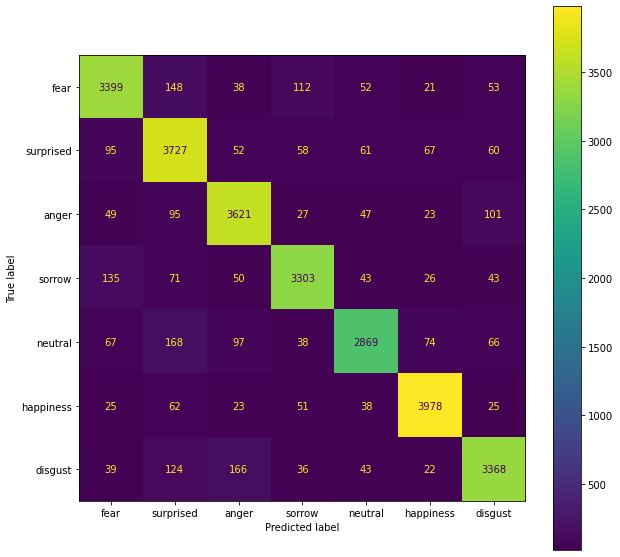

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
labels = ['fear', 'surprised', 'anger', 'sorrow', 'neutral', 'happiness', 'disgust']
plot_confusion_matrix(svc, X_train_tf, y_train, display_labels=labels, values_format = '0.0f', ax=ax)

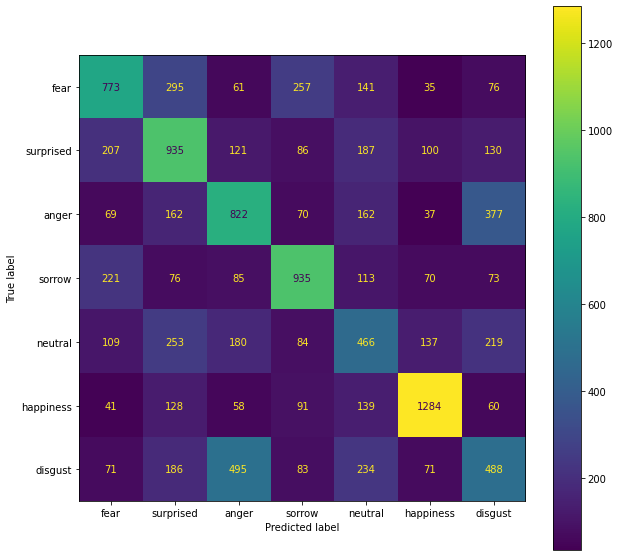

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svc, X_test_tf, y_test, display_labels=labels, values_format = '.0f', ax=ax)

# SVM gridsearch

In [54]:
param_grid_svc = {'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.8]}
grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=3)

In [55]:
grid_svc.fit(X_train_tf, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
grid_svc.cv_results_

{'mean_fit_time': array([60.03, 60.11, 58.93, 54.57, 53.8 , 54.64]),
 'mean_score_time': array([15.73, 15.69, 15.64, 15.32, 15.08, 15.13]),
 'mean_test_score': array([0.16, 0.27, 0.36, 0.44, 0.46, 0.47]),
 'param_C': masked_array(data=[0.01, 0.05, 0.1, 0.3, 0.5, 0.8],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01},
  {'C': 0.05},
  {'C': 0.1},
  {'C': 0.3},
  {'C': 0.5},
  {'C': 0.8}],
 'rank_test_score': array([6, 5, 4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([0.16, 0.27, 0.36, 0.43, 0.46, 0.46]),
 'split1_test_score': array([0.16, 0.27, 0.37, 0.44, 0.47, 0.48]),
 'split2_test_score': array([0.16, 0.27, 0.36, 0.43, 0.46, 0.47]),
 'std_fit_time': array([0.04, 0.36, 0.35, 0.23, 0.14, 0.14]),
 'std_score_time': array([0.09, 0.1 , 0.14, 0.11, 0.09, 0.12]),
 'std_test_score': array([0.  , 0.  , 0.  , 0.01, 0.  , 0.01])}

# Logistic Regression 사용 acc=0.4911

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_tf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
print(accuracy_score(y_train, lr.predict(X_train_tf)))
print(accuracy_score(y_test, lr.predict(X_test_tf)))

0.6546594450215165
0.4911278455812343


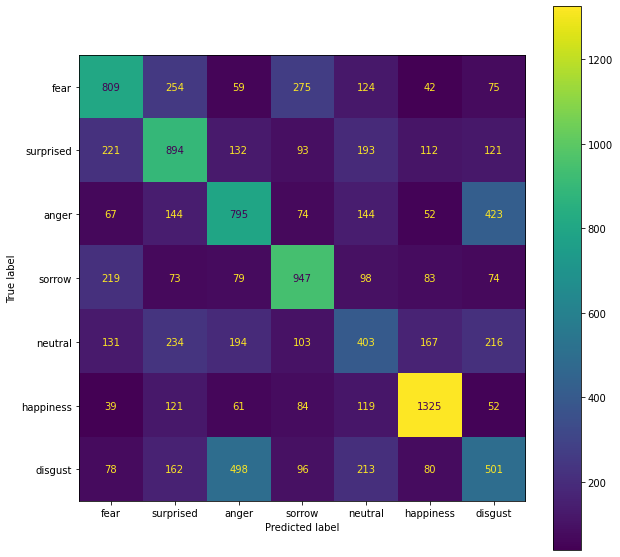

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(lr, X_test_tf, y_test, display_labels=labels, values_format = '.0f', ax=ax)

# decision tree & random forest

In [60]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [61]:
print(accuracy_score(y_train, tree.predict(X_train_tf)))
print(accuracy_score(y_test, tree.predict(X_test_tf)))

0.9970322006232378
0.3573963472691076


In [62]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_tf, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
print(accuracy_score(y_train, rfc.predict(X_train_tf)))
print(accuracy_score(y_test, rfc.predict(X_test_tf)))

0.9970322006232378
0.4453388730199948


# 결과
* NB(alpha=4): 0.4862
* SVC(C=1): 0.4936
* Logistic Regression: 0.4911
* Decision Tree: 0.3529 (pruning 안함)
* Random Forest: 0.4419 (pruning 안함)


## 제일 accuracy가 높게 나온 svc(0.4936)로 실제로 내가 쓸법한 말을 분류해봄.

In [64]:
while True:
  input_sent = input()
  if input_sent == '끝':
    break
  e_nor = emoticon_normalize(input_sent, num_repeats=2)
  tokenized = okt.morphs(e_nor, stem=True)
  sw_removed = [word for word in tokenized if not word in stopwords]
  normalized = []
  for word in sw_removed:
    changed = False
    for n in norm: ## 두번 이상 나온 이모티콘 정규화
      if n in word:
        normalized.append(n)
        changed = True
    if 'ㅜ' in word: ## ㅜ를 ㅠ로 변환
      normalized.append('ㅠ')
      changed = True
    
    if not changed:
      normalized.append(word)
  sent_bow = vectorizer.transform([input_sent]).toarray()
  sent_tfidf = tfidf.transform(sent_bow)
  sent_pred = svc.predict(sent_tfidf)
  print(enc.inverse_transform(sent_pred))

이번 에스파 신곡 진짜 좋아ㅠㅠ
['슬픔']
이번 에스파 신곡 진짜 좋아!!
['행복']
나 휴강이당ㅎㅎ
['행복']
아니다 휴강 아니었음...
['혐오']
아주 잘 하는 짓이다
['분노']
헐 내일 중간발표라고??
['놀람']
아니 소속사 뭐하냐
['분노']
애들 케어 안함??
['놀람']
저는 오늘 비빔밥을 먹었습니다. 
['중립']
나 오늘 비빔밥 먹었당ㅎ
['행복']
끝


* 문장의 작은 부분만 바꿔도 감정이 다르게 분류됨. 

# 참고문헌

* sklearn.org
* 머신러닝 교과서 with 파이썬, 사이킷런, 텐서플로 _세바스찬 라시카, 바히드 미자리리
* 딥 러닝을 이용한 자연어처리 입문 _유원준 외 1명 (wikidocs.net/book/2155)

# 앞으로 할것
* 감성 사전 사용해보기
* word기반이 아닌 char 기반도
* word2vec, fasttext 사용해보기
* 이모티콘과 특수문자 빼고
* CNN, LSTM 사용해보기

# 의문점, 고민점
* 이모티콘이 너무 과한 영향을 주나? 예) 너무 예뻐ㅠㅠㅠㅠㅠ -> 슬픔, 짜증난다ㅋㅋㅋㅋ -> 행복
* 왜 SVM은 오버피팅 되었을까?